In [3]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [63]:


NUM_FOLD = 3

train = pd.read_csv('../dataset/train.csv', index_col='id')
test = pd.read_csv('../dataset/test.csv', index_col='id')


cat_cols = list(test.select_dtypes(include=['object']).columns)
print(cat_cols)

for df in [train, test]:
    for col in cat_cols:
        df[col] = df[col].astype('str').astype('category')
        # df[col] = df[col].astype('str')

# train['person_home_ownership'] = train['person_home_ownership'].astype(str)
# test['person_home_ownership'] = test['person_home_ownership'].astype(str)



X = train.drop(['loan_status'], axis=1)
y = train['loan_status']

X, _, y, _ = train_test_split(X, y, test_size=0.8, random_state=42, stratify=y)



['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']


In [64]:
# # train.info()
# for col in cat_cols:
#     print(col)
#     print(train[col].value_counts())
#     print(test[col].value_counts())
#     print('')

In [65]:
# def objective_func(trial):
#     params = {
#         'n_estimators': 1000,
#         'learning_rate': 0.01,
#         'max_depth': trial.suggest_int('max_depth', 3, 10),
#         'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
#         'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
#         'gamma': trial.suggest_uniform('gamma', 0.0, 0.5),
#         'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
#         'reg_alpha': trial.suggest_uniform('reg_alpha', 0.0, 1.0),
#         'reg_lambda': trial.suggest_uniform('reg_lambda', 0.0, 1.0),
#         'random_state': 0,
#         'n_jobs': -1,
#         'tree_method': 'gpu_hist',
#         'predictor': 'gpu_predictor'
#     }

#     skf = StratifiedKFold(n_splits=NUM_FOLD, shuffle=True, random_state=0)
#     scores = []
#     for train_idx, valid_idx in skf.split(X, y):
#         X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
#         y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

#         model = XGBClassifier(**params)
#         model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], early_stopping_rounds=100, verbose=False)
#         y_pred = model.predict_proba(X_valid)[:, 1]
#         score = roc_auc_score(y_valid, y_pred)
#         scores.append(score)

#     return np.mean(scores)

In [66]:
def objective_func(trial):

# # test 1
#     params = {
#     'iterations': trial.suggest_int('iterations', 200, 1000),
#     'depth': trial.suggest_int('depth', 3, 15),
#     'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.1),
#     'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0, 10),
#     'border_count': trial.suggest_int('border_count', 32, 256),
#     'random_strength': trial.suggest_float('random_strength', 0.5, 8),
#     'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1.5),
#     # 'bootstrap_type': trial.suggest_categorical('bootstrap_type', ['Bayesian', 'Bernoulli']),
#     'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1, 10),
#     'verbose': False,
#     'task_type': 'CPU',
# }

    # # test 2
    # params = {
    #     'iterations': trial.suggest_int('iterations', 600, 1500),
    #     'depth': trial.suggest_int('depth', 1, 8),
    #     'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
    #     'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 6, 15),
    #     'border_count': trial.suggest_int('border_count', 190, 300),
    #     'random_strength': trial.suggest_float('random_strength', 6, 12),
    #     'bagging_temperature': trial.suggest_float('bagging_temperature', 0.5, 1.5),
    #     'scale_pos_weight': trial.suggest_float('scale_pos_weight', 0, 8),
    #     'verbose': False,
    #     'task_type': 'CPU',
    # }

    # test 3
    params = {
        'iterations': trial.suggest_int('iterations', 800, 1500),
        'depth': trial.suggest_int('depth', 2, 6),
        'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.1),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 5, 10),
        'border_count': trial.suggest_int('border_count', 210, 350),
        'random_strength': trial.suggest_float('random_strength', 4,10),
        'bagging_temperature': trial.suggest_float('bagging_temperature',1,2),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 2, 8),
        'verbose': False,
        'task_type': 'CPU',
    }


    skf = StratifiedKFold(n_splits=NUM_FOLD, shuffle=True, random_state=42)
    scores = []

    for train_idx, valid_idx in skf.split(X, y):
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

        model = CatBoostClassifier(**params,cat_features=cat_cols)
        model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], early_stopping_rounds=100, verbose=False)
        y_pred = model.predict_proba(X_valid)[:, 1]
        score = roc_auc_score(y_valid, y_pred)
        scores.append(score)

    return np.mean(scores)

In [67]:
import optuna
study = optuna.create_study(direction='maximize', study_name='catboost')
study.optimize(objective_func, n_trials=50)

[I 2024-10-14 11:02:10,376] A new study created in memory with name: catboost
[I 2024-10-14 11:02:18,288] Trial 0 finished with value: 0.9444188221592883 and parameters: {'iterations': 1171, 'depth': 3, 'learning_rate': 0.08730001065254281, 'l2_leaf_reg': 6.49608236156072, 'border_count': 250, 'random_strength': 7.10500113703489, 'bagging_temperature': 1.8711261410956084, 'scale_pos_weight': 3.61785929465903}. Best is trial 0 with value: 0.9444188221592883.
[I 2024-10-14 11:02:25,807] Trial 1 finished with value: 0.9434513979471056 and parameters: {'iterations': 1012, 'depth': 3, 'learning_rate': 0.09455849148087528, 'l2_leaf_reg': 7.213745550575636, 'border_count': 238, 'random_strength': 6.890887628274032, 'bagging_temperature': 1.39774044291482, 'scale_pos_weight': 2.64379218999511}. Best is trial 0 with value: 0.9444188221592883.
[I 2024-10-14 11:02:31,154] Trial 2 finished with value: 0.939192024613901 and parameters: {'iterations': 933, 'depth': 6, 'learning_rate': 0.089043438133

In [68]:
study.best_value, study.best_params

(0.9457814525314684,
 {'iterations': 1096,
  'depth': 3,
  'learning_rate': 0.09168434119589226,
  'l2_leaf_reg': 6.448523852836537,
  'border_count': 338,
  'random_strength': 7.510999845955329,
  'bagging_temperature': 1.8214407526464864,
  'scale_pos_weight': 2.484717579219497})

In [5]:

NUM_FOLD = 5

train = pd.read_csv('../dataset/train.csv', index_col='id')
test = pd.read_csv('../dataset/test.csv', index_col='id')
original = pd.read_csv('../dataset/original.csv')
sample_submission = pd.read_csv('../dataset/sample_submission.csv')

# accepted_cols = ['person_income', 'person_home_ownership', 'loan_intent',
#        'loan_grade', 'loan_int_rate', 'loan_percent_income','loan_status']

# train = train[accepted_cols]
# original = original[accepted_cols]
# accepted_cols.remove("loan_status")
# test = test[accepted_cols]



cat_cols = list(test.select_dtypes(include=['object']).columns)

for df in [train, test, original]:
    for col in cat_cols:
        df[col] = df[col].astype('str').astype('category')


X = train.drop(['loan_status'], axis=1)
y = train['loan_status']
X_original = original.drop(['loan_status'], axis=1)
y_original = original['loan_status']





In [6]:

val_scores = []
test_preds_model = []

skf = StratifiedKFold(n_splits=NUM_FOLD, shuffle=True, random_state=42)

# # test 1
# params = {'iterations': 851,
#  'depth': 4,
#  'learning_rate': 0.06494509431596682,
#  'l2_leaf_reg': 8.746710106832758,
#  'border_count': 235,
#  'random_strength': 7.170782740118952,
#  'bagging_temperature': 1.1593003068750296,
#  'scale_pos_weight': 4.225078016431598}

# test 2
params = {'iterations': 1210,
  'depth': 3,
  'learning_rate': 0.06911827924093912,
  'l2_leaf_reg': 7.31536976872598,
  'border_count': 270,
  'random_strength': 7.740387767020672,
  'bagging_temperature': 1.4998527262934331,
  'scale_pos_weight': 5.665303215654214}

for Fold, (train_index, val_index) in enumerate(skf.split(X, y)):

    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y[train_index], y[val_index]

    X_train = pd.concat([X_train, X_original], axis=0)
    y_train = pd.concat([y_train, y_original]) 

    model = CatBoostClassifier(**params,cat_features=cat_cols)
    # model.fit(X_train, y_train)
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=100, verbose=False)

    y_pred = model.predict_proba(X_val)[:, 1]

    roc_auc_score_ = roc_auc_score(y_val, y_pred)

    print(f'Fold {Fold}: roc_auc_score= {roc_auc_score_:.5f}')

    val_scores.append(roc_auc_score_)

    test_preds_model.append(model.predict_proba(test)[:, 1])

test_preds_model = sum(test_preds_model)/len(test_preds_model)

print(f'mean validation roc_auc_score = {np.mean(val_scores):.5f}')
print(f'std validation roc_auc_score = {np.std(val_scores):.5f}')


Fold 0: roc_auc_score= 0.95439
Fold 1: roc_auc_score= 0.96501
Fold 2: roc_auc_score= 0.95704
Fold 3: roc_auc_score= 0.96156
Fold 4: roc_auc_score= 0.96017
mean validation roc_auc_score = 0.95963
std validation roc_auc_score = 0.00367


<Axes: ylabel='names'>

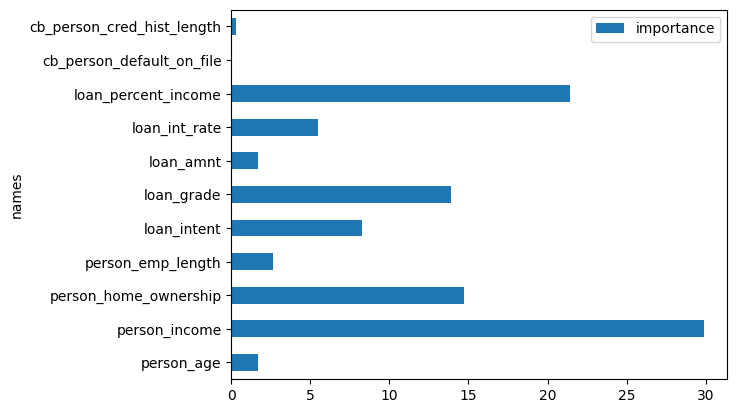

In [7]:
d = pd.DataFrame({"names": model.feature_names_,"importance":model.feature_importances_})
d.plot(kind='barh',x='names',y='importance')

In [10]:
# d[d['importance'] > 3].names.values
d.sort_values(by='importance',ascending=False)

,names,importance
1,person_income,29.873006
8,loan_percent_income,21.402642
2,person_home_ownership,14.690587
5,loan_grade,13.875938
4,loan_intent,8.290563
7,loan_int_rate,5.486004
3,person_emp_length,2.655817
0,person_age,1.703581
6,loan_amnt,1.698145
10,cb_person_cred_hist_length,0.267394


In [57]:
# visualize optuna study
import optuna.visualization as ov

ov.plot_param_importances(study).show()

In [47]:
ov.plot_optimization_history(study).show()

In [69]:
ov.plot_slice(study).show()

In [70]:
ov.plot_optimization_history(study).show()

In [71]:
ov.plot_slice(study).show()

In [ ]:
def objective_func(trial):
    # test 3
    params = {
        'iterations': trial.suggest_int('iterations', 800, 1500),
        'depth': trial.suggest_int('depth', 2, 6),
        'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.1),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 5, 10),
        'border_count': trial.suggest_int('border_count', 210, 350),
        'random_strength': trial.suggest_float('random_strength', 4,10),
        'bagging_temperature': trial.suggest_float('bagging_temperature',1,2),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 2, 8),
        'verbose': False,
        'task_type': 'CPU',
    }


    skf = StratifiedKFold(n_splits=NUM_FOLD, shuffle=True, random_state=42)
    scores = []

    for train_idx, valid_idx in skf.split(X, y):
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

        model = CatBoostClassifier(**params,cat_features=cat_cols)
        model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], early_stopping_rounds=100, verbose=False)
        y_pred = model.predict_proba(X_valid)[:, 1]
        score = roc_auc_score(y_valid, y_pred)
        scores.append(score)

    return np.mean(scores)